## Importing Libraries

In [39]:
import json
import matplotlib.pyplot as plt

import asyncio
from time import perf_counter
import aiohttp
import requests
from tqdm import tqdm
from time import sleep

### A-1  <font size="5">Sending 10,000 async requests on N=3 servers</font> 


In [9]:
## Make sure that no servers have been added yet (Servers will be added from here)

# Creating 3 servers for testing

LOAD_BALANCER_URL = "http://localhost:5000"

json_data = {
    "n": 3,
    "hostnames": ["serv_1", "serv_2", "serv_3"]
}

response = requests.post(LOAD_BALANCER_URL+"/add", json=json_data)
response.text

'{"message":{"N":3,"replicas":["serv_1","serv_2","serv_3"]},"status":"successful"}'

In [13]:

async def fetch(session):
    async with session.get(LOAD_BALANCER_URL+"/home") as r:
        if r.status != 200:
            r.raise_for_status()
        res=await r.text()
        return res
    
async def fetch_all(session, req_count):
    tasks = []
    for i in range(req_count):
        task = asyncio.create_task(fetch(session))
        tasks.append(task)
    res = await asyncio.gather(*tasks)
    return res

In [32]:
REQUEST_COUNT = 100
start = perf_counter()
async with aiohttp.ClientSession() as session:
    htmls = await fetch_all(session,    REQUEST_COUNT)
end = perf_counter()
print(f"Time taken to complete {REQUEST_COUNT} requests: {end-start:.2f} seconds")

Time taken to complete 100 requests: 0.36 seconds
Time taken to complete 100 requests: 0.32 seconds
Time taken to complete 100 requests: 0.29 seconds


In [19]:
# Count occurrences of each server
data = [json.loads(html) for html in htmls]
server_counts = {}
for entry in data:
    server_name = entry["message"].split(":")[1]
    if server_name in server_counts:
        server_counts[server_name] += 1
    else:
        server_counts[server_name] = 1


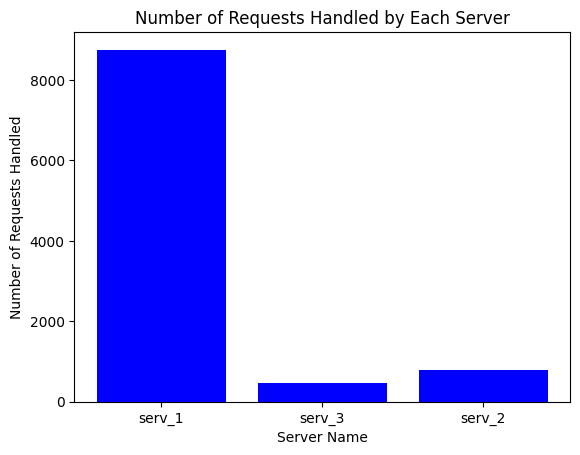

In [20]:

# Plot the bar graph
servers = list(server_counts.keys())
counts = list(server_counts.values())

plt.bar(servers, counts, color='blue')
plt.xlabel('Server Name')
plt.ylabel('Number of Requests Handled')
plt.title('Number of Requests Handled by Each Server')
plt.show()


In [21]:
# Remove the Added Servers
response = requests.delete(LOAD_BALANCER_URL+"/rm", json=json_data)
response.text

'"deleted the server"'

### A-2  <font size="5"> Increment N from 2 to 6 and launch 10000 requests on each such increment</font> 

In [54]:
def get_server_loads(htmls, server_list):
    data = [json.loads(html) for html in htmls]
    server_load = dict(zip(server_list, [0]*len(server_list)))
        
    for entry in data:
        server_name = entry["message"].split(":")[1]
        server_load[server_name] += 1

    return server_load



{"message":{"N":1,"replicas":["serv_1"]},"status":"successful"}
Time taken to complete 10000 requests with 1 servers: 27.39 seconds
{"message":{"N":2,"replicas":["serv_1","serv_2"]},"status":"successful"}
Time taken to complete 10000 requests with 2 servers: 24.86 seconds
{"message":{"N":3,"replicas":["serv_1","serv_2","serv_3"]},"status":"successful"}
Time taken to complete 10000 requests with 3 servers: 25.37 seconds
{"message":{"N":4,"replicas":["serv_1","serv_2","serv_3","serv_4"]},"status":"successful"}
Time taken to complete 10000 requests with 4 servers: 26.66 seconds
{"message":{"N":5,"replicas":["serv_1","serv_2","serv_3","serv_4","serv_5"]},"status":"successful"}
Time taken to complete 10000 requests with 5 servers: 26.16 seconds
{"message":{"N":6,"replicas":["serv_1","serv_2","serv_3","serv_4","serv_5","serv_6"]},"status":"successful"}
Time taken to complete 10000 requests with 6 servers: 26.70 seconds


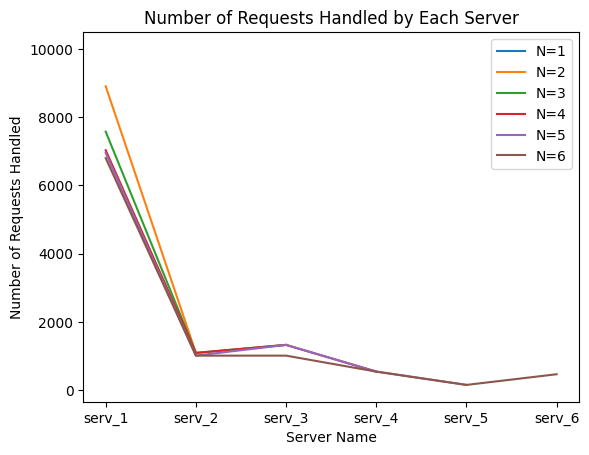

"deleted the server"


In [56]:
server_names = []
for server_count in range(2, 7):
    
    while server_count > len(server_names):
        new_server_name = "serv_"+str(len(server_names)+1)
        response = requests.post(LOAD_BALANCER_URL+"/add", json={"n":1, "hostnames":[new_server_name]})
        print(response.text)
        if response.status_code == 200:
            server_names.append("serv_"+str(len(server_names)+1))
    sleep(1)
        
    
    REQUEST_COUNT = 10000
    start = perf_counter()
    async with aiohttp.ClientSession() as session:
        htmls = await fetch_all(session, REQUEST_COUNT)
    end = perf_counter()
    print(f"Time taken to complete {REQUEST_COUNT} requests with {len(server_names)} servers: {end-start:.2f} seconds")
    
    server_load = get_server_loads(htmls, server_names)
    
    # print(server_names) 
    # print(server_load)
    # print(server_load.values())
    
    
    plt.plot(server_names, server_load.values(), label=f"N={len(server_names)}")
   
plt.xlabel('Server Name')
plt.ylabel('Number of Requests Handled')
plt.title('Number of Requests Handled by Each Server')
plt.legend()
plt.show() 
delete_response = requests.delete(LOAD_BALANCER_URL+"/rm", json={"n":len(server_names), "hostnames":server_names})
print(delete_response.text)